In [1]:
from src.base import Block, Boxtype
import src.vcs_function as eval
import src.box_plotter as bxplot
import time
import pandas as pd

#test Blocks
b1 = Block(boxtype=Boxtype(1,2,4,True,True,True,1), rot='wlh')
b2 = Block(boxtype=Boxtype(1,2,3,True,True,True,1), rot='lwh')
b3 = Block(boxtype=Boxtype(1,1,2,True,True,True,1), rot='hwl')

#test join
print("b1:",b1); print("b2:",b2); print("b3:",b3)
t=b1.join(b2, 'y'); print(t,"b1+b2:",b1)
t=b1.join(b3, 'z'); print(t,"b1+b3:",b1)
t=b1.join(b1, 'x'); print(t,"b1+b1:",b1)

b1: Block: l: 4 w: 2 h: True weight: 1 stacking_weight_resistance: 1000 volume: 8 occupied_volume: 8 items: {<src.base.Boxtype object at 0x10d6a36d0>: 1} ratio:1.0
b2: Block: l: 2 w: 3 h: True weight: 1 stacking_weight_resistance: 1000 volume: 6 occupied_volume: 6 items: {<src.base.Boxtype object at 0x10e331e10>: 1} ratio:1.0
b3: Block: l: True w: 2 h: 1 weight: 1 stacking_weight_resistance: 1000 volume: 2 occupied_volume: 2 items: {<src.base.Boxtype object at 0x10d35e710>: 1} ratio:1.0
False b1+b2: Block: l: 4 w: 2 h: True weight: 1 stacking_weight_resistance: 1000 volume: 8 occupied_volume: 8 items: {<src.base.Boxtype object at 0x10d6a36d0>: 1} ratio:1.0
False b1+b3: Block: l: 4 w: 2 h: True weight: 1 stacking_weight_resistance: 1000 volume: 8 occupied_volume: 8 items: {<src.base.Boxtype object at 0x10d6a36d0>: 1} ratio:1.0
True b1+b1: Block: l: 8 w: 2 h: True weight: 2 stacking_weight_resistance: 1000 volume: 16 occupied_volume: 16 items: {<src.base.Boxtype object at 0x10d6a36d0>: 2

## Plot container

In [2]:
def load_instance(filename = "instancia.txt", type="BF", id_instance=5):
    with open(filename, "r") as file:
        #discard first line
        file.readline()
      
        for j in range(100):
            file.readline()
            L, W, H, WEIGHT,SUPPORTED_WEIGHT = [int(x) for x in file.readline().split()]

            #read second line
            n = int(file.readline())
            #read n lines
            items = Itemdict()
            for i in range(n):
                id, l, rotx, w, roty, h, rotz, n, weight, supported_weight = [int(x) for x in file.readline().split()]    
                item = Boxtype(id, l, w, h, rotx, roty, rotz, weight, supported_weight)
                items[item]=n
            
            if j == id_instance: return  items, L, W, H, WEIGHT, SUPPORTED_WEIGHT

In [3]:
def adyacent_blocks(blocks,L,W,H):
    last = blocks[-1]
    adyacent = list()
    box_dims = []
    
    for block in blocks[:-1]:
        
        if block.xmax == last.xmin and ((block.zmin < last.zmax and block.zmax > last.zmin ) and (block.ymin < last.ymax and block.ymax > last.ymin )):
            z_diff_max = max([block.zmin,last.zmin])
            z_diff_min = min([block.zmax,last.zmax])
            y_diff_max = max([block.ymin,last.ymin])
            y_diff_min = min([block.ymax,last.ymax])
            adyacent.append(block)
            block.covered_surface+= (z_diff_min-z_diff_max) * (y_diff_min-y_diff_max)
            block.covered_surface_face['X1']+= (z_diff_min-z_diff_max) * (y_diff_min-y_diff_max)
            last.covered_surface+= (z_diff_min-z_diff_max) * (y_diff_min-y_diff_max)
            last.covered_surface_face['X2']+= (z_diff_min-z_diff_max) * (y_diff_min-y_diff_max)

        elif block.xmin == last.xmax and ((block.zmin < last.zmax and block.zmax > last.zmin ) and (block.ymin < last.ymax and block.ymax > last.ymin )):
            z_diff_max = max([block.zmin,last.zmin])
            z_diff_min = min([block.zmax,last.zmax])
            y_diff_max = max([block.ymin,last.ymin])
            y_diff_min = min([block.ymax,last.ymax])
            adyacent.append(block)
            block.covered_surface+= (z_diff_min-z_diff_max) * (y_diff_min-y_diff_max)
            block.covered_surface_face['X2']+= (z_diff_min-z_diff_max) * (y_diff_min-y_diff_max)
            last.covered_surface+= (z_diff_min-z_diff_max) * (y_diff_min-y_diff_max)
            last.covered_surface_face['X1']+= (z_diff_min-z_diff_max) * (y_diff_min-y_diff_max)

        elif block.ymax == last.ymin and ((block.zmin < last.zmax and block.zmax > last.zmin ) and (block.xmin < last.xmax and block.xmax > last.xmin )):
            z_diff_max = max([block.zmin,last.zmin])
            z_diff_min = min([block.zmax,last.zmax])
            x_diff_max = max([block.xmin,last.xmin])
            x_diff_min = min([block.xmax,last.xmax])
            adyacent.append(block)
            block.covered_surface+= (z_diff_min-z_diff_max) * (x_diff_min-x_diff_max)
            block.covered_surface_face['Y1']+= (z_diff_min-z_diff_max) * (x_diff_min-x_diff_max)
            last.covered_surface+= (z_diff_min-z_diff_max) * (x_diff_min-x_diff_max)
            last.covered_surface_face['Y2']+= (z_diff_min-z_diff_max) * (x_diff_min-x_diff_max)

        elif block.ymin == last.ymax and ((block.zmin < last.zmax and block.zmax > last.zmin ) and (block.xmin < last.xmax and block.xmax > last.xmin )):
            z_diff_max = max([block.zmin,last.zmin])
            z_diff_min = min([block.zmax,last.zmax])
            x_diff_max = max([block.xmin,last.xmin])
            x_diff_min = min([block.xmax,last.xmax])
            adyacent.append(block)
            block.covered_surface+= (z_diff_min-z_diff_max) * (x_diff_min-x_diff_max)
            block.covered_surface_face['Y2']+= (z_diff_min-z_diff_max) * (x_diff_min-x_diff_max)
            last.covered_surface+= (z_diff_min-z_diff_max) * (x_diff_min-x_diff_max)
            last.covered_surface_face['Y1']+= (z_diff_min-z_diff_max) * (x_diff_min-x_diff_max)

        elif block.zmax == last.zmin and ((block.ymin < last.ymax and block.ymax > last.ymin ) and (block.xmin < last.xmax and block.xmax > last.xmin )):
            y_diff_max = max([block.ymin,last.ymin])
            y_diff_min = min([block.ymax,last.ymax])
            x_diff_max = max([block.xmin,last.xmin])
            x_diff_min = min([block.xmax,last.xmax])
            adyacent.append(block)
            block.covered_surface+= (y_diff_min-y_diff_max) * (x_diff_min-x_diff_max)
            # block.covered_surface_face['Z1']+= (y_diff_min-y_diff_max) * (x_diff_min-x_diff_max)
            last.covered_surface+= (y_diff_min-y_diff_max) * (x_diff_min-x_diff_max)
            # last.covered_surface_face['Z2']+= (y_diff_min-y_diff_max) * (x_diff_min-x_diff_max)

        elif block.zmin == last.zmax and ((block.ymin < last.ymax and block.ymax > last.ymin ) and (block.xmin < last.xmax and block.xmax > last.xmin )):
            y_diff_max = max([block.ymin,last.ymin])
            y_diff_min = min([block.ymax,last.ymax])
            x_diff_max = max([block.xmin,last.xmin])
            x_diff_min = min([block.xmax,last.xmax])
            adyacent.append(block)
            block.covered_surface+= (y_diff_min-y_diff_max) * (x_diff_min-x_diff_max)
            # block.covered_surface_face['Z2']+= (y_diff_min-y_diff_max) * (x_diff_min-x_diff_max)
            last.covered_surface+= (y_diff_min-y_diff_max) * (x_diff_min-x_diff_max)
            # last.covered_surface_face['Z1']+= (y_diff_min-y_diff_max) * (x_diff_min-x_diff_max)
            
    # if(len(adyacent)!=0):
        # print(last.covered_surface_face)
        # box_dims.append([last.xmin,last.ymin,last.zmin,last.xmax,last.ymax,last.zmax])
        # for aabb in adyacent:
        #     box_dims.append([aabb.xmin,aabb.ymin,aabb.zmin,aabb.xmax,aabb.ymax,aabb.zmax])
        # bxplot.plot_container([L,W,H], box_dims)
    pass

# The main code

In [4]:

from src.base import Itemdict, BlockList, Aabb, Space
from src.restrictions import center_of_gravity

def MLCP_function(alpha,beta,gamma,delta,p,instance,weight_restriction=False, max_distance_cg=-1):

  start_time = time.time()

  params = [alpha,beta,gamma,delta,p]

  Space.filling = "bottom-up" #"bottom-up" # spaces are filled from bottom to top
  Space.vertical_stability = True#False # boxes must be completly supported

  items, L, W, H, WEIGHT,SUPPORTED_WEIGHT = load_instance(filename = "src/BR4.txt", type="BF", id_instance=instance)

  cont = Block(l=L,w=W,h=H,weight=WEIGHT,stacking_weight_resistance=SUPPORTED_WEIGHT)

  # print("generating blocks...")
  blocks = BlockList(items, type="general_blocks", cont=cont, min_fr=1.0, max_bl=1000) 

  # for x in blocks:
  #    print(x.items.values())

  import csv

  # greedy for single CLP
  while True:
      space = cont.free_space.closest_space() #cuboide mas cercano a un vertice inferior del contenedor

      

      if space is not None:
        print("?????????????")
        print("volumen space: ", space.volume)
        csv_filename = "HISTORIAL_SPACEEEEE.csv"
        with open(csv_filename, mode='a', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerow([space.volume])

        block = eval.eval_function(blocks,space,params=params,container=cont,items=items, weight_restriction=weight_restriction,  max_distance_cg=max_distance_cg)

        if block is None: #si es none es porque no se cumple la restriccion CG o Stacking
          print("block is None !!!!!!!!")
          break

        # print("adding block...", block)
        if block is not None:
          cont.add_block(block, space)
          adyacent_blocks(cont.aabbs,L,W,H)
          items -= block.items
          blocks.remove_unconstructable(items)
          cont.free_space.filter(items)
      else:
          break

  end_time = time.time()

  execution_time = end_time - start_time

  total_volume = sum([x.volume for x in cont.aabbs])

  return cont,execution_time,total_volume

  # print(f'tiempo: {execution_time} s ; volumen total: {cont.l * cont.w * cont.h} ; volumen ocupado: {total_volume} ; centro de gravedad: {center_of_gravity(cont)}')


# Plot the solution

In [5]:
cont, execution_time,total_volume = MLCP_function(alpha=4.0,beta=1.0,gamma=0.2,delta=0.5,p=0.05,instance=1,weight_restriction=True, max_distance_cg=10000)
print("cont despues de ejecutar MLCP")
print(cont)
L = cont.l;W = cont.w; H = cont.h

box_dims = []
for aabb in cont.aabbs:
  box_dims.append([aabb.xmin,aabb.ymin,aabb.zmin,aabb.xmax,aabb.ymax,aabb.zmax])

bxplot.plot_container([L,W,H], box_dims)


?????????????
volumen space:  30089620
posible blocks: 1000
posible blocks que cumplen restriccion de peso: 1000
--------------
creando archivo HISTORIAL_SALIDA_APILAMIENTO.csv
?????????????
volumen space:  20274980
posible blocks: 855
posible blocks que cumplen restriccion de peso: 855
--------------
creando archivo HISTORIAL_SALIDA_APILAMIENTO.csv
?????????????
volumen space:  8970500
posible blocks: 814
posible blocks que cumplen restriccion de peso: 814
--------------
creando archivo HISTORIAL_SALIDA_APILAMIENTO.csv
?????????????
volumen space:  13603700
posible blocks: 834
posible blocks que cumplen restriccion de peso: 834
--------------
creando archivo HISTORIAL_SALIDA_APILAMIENTO.csv
?????????????
volumen space:  4758208
posible blocks: 677
posible blocks que cumplen restriccion de peso: 549
--------------
creando archivo HISTORIAL_SALIDA_APILAMIENTO.csv
?????????????
volumen space:  4884672
posible blocks: 476
posible blocks que cumplen restriccion de peso: 442
--------------


In [6]:
ALPHA = [0.0,1.0,2.0,3.0]
BETA = [0.0,1.0,2.0,3.0]
GAMMA = [0.0,0.1,0.2,0.3]
DELTA = [0.0,0.2,0.4,0.6]
P = [0.00,0.01,0.02,0.03]
INSTANCE = range(0,100)

In [7]:
#data = []
#for i in INSTANCE:
#    cont, execution_time,total_volume = MLCP_function(alpha=1,beta=0,gamma=0,delta=1,p=0,instance=i)
 #   data.append([i,execution_time,total_volume,center_of_gravity(cont),1,0,0,1,0])


In [8]:
df = pd.DataFrame(data,columns=['Instancia','Tiempo ejecucion','Volumen Ocupado','Diferencia centro','alpha','beta','gamma','delta','p'])

NameError: name 'data' is not defined

In [ ]:
df

,Instancia,Tiempo ejecucion,Volumen Ocupado,Diferencia centro,alpha,beta,gamma,delta,p
0,0,0.152187,30270728,55.091423,1,0,0,1,0
1,1,0.266247,32852514,9.925250,1,0,0,1,0
2,2,0.197234,29954098,6.744650,1,0,0,1,0
3,3,0.271764,32847850,7.353906,1,0,0,1,0
4,4,0.197970,32412250,21.104925,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...
95,95,0.198988,32732524,14.613806,1,0,0,1,0
96,96,0.218070,33296962,32.147239,1,0,0,1,0
97,97,0.193709,32738228,12.766965,1,0,0,1,0
98,98,0.218923,31900752,16.854127,1,0,0,1,0


In [ ]:
print(f'{df["Volumen Ocupado"].mean()}  {df["Diferencia centro"].mean()}')

32213638.52  17.568647166783833


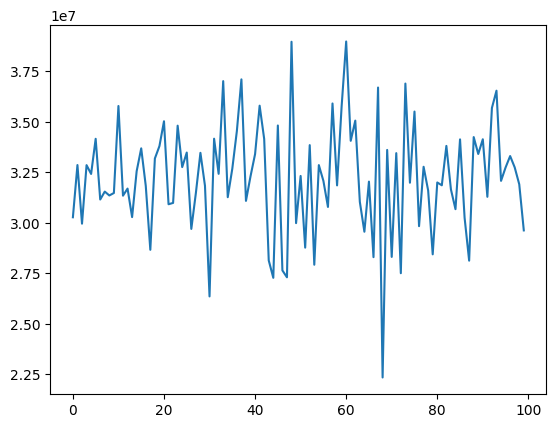

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
ax.plot(df['Instancia'],df['Volumen Ocupado'])
plt.savefig('InstanciaVSVolumen.jpg')

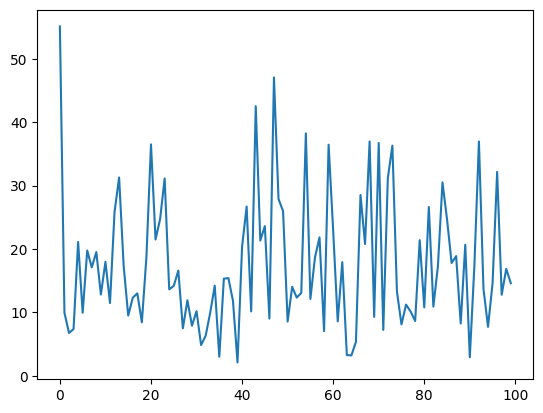

In [ ]:
fig,ax = plt.subplots()
ax.plot(df['Instancia'],df['Diferencia centro'])
plt.savefig('InstanciaVSCentro.jpg')

In [ ]:
df.to_csv('resultados_parametros2.csv')

In [ ]:
# cont, execution_time,total_volume = MLCP_function(alpha=1,beta=0.0,gamma=0,delta=0,p=0,instance=2)
# cont, execution_time,total_volume = MLCP_function(alpha=1.0,beta=3.0,gamma=0.1,delta=0.2,p=0.02,instance=2)

L = cont.l;W = cont.w; H = cont.h

box_dims = []
for aabb in cont.aabbs:
  box_dims.append([aabb.xmin,aabb.ymin,aabb.zmin,aabb.xmax,aabb.ymax,aabb.zmax])

bxplot.plot_container([L,W,H], box_dims)


In [ ]:
#data = []
#for i in INSTANCE:
#    cont, execution_time,total_volume = MLCP_function(alpha=1.0,beta=3.0,gamma=0.1,delta=0.2,p=0.02,instance=i)
#    data.append([i,execution_time,total_volume,center_of_gravity(cont),1,0,0,1,0])

posible blocks: 1000
posible blocks que cumplen restriccion de peso: 1000
--------------
posible blocks: 642
posible blocks que cumplen restriccion de peso: 642
--------------
posible blocks: 425
posible blocks que cumplen restriccion de peso: 162
--------------
posible blocks: 150
posible blocks que cumplen restriccion de peso: 86
--------------
posible blocks: 194
posible blocks que cumplen restriccion de peso: 0
--------------
posible blocks: 86
posible blocks que cumplen restriccion de peso: 0
--------------
posible blocks: 52
posible blocks que cumplen restriccion de peso: 52
--------------
posible blocks: 30
posible blocks que cumplen restriccion de peso: 30
--------------
posible blocks: 62
posible blocks que cumplen restriccion de peso: 0
--------------
posible blocks: 30
posible blocks que cumplen restriccion de peso: 0
--------------
posible blocks: 48
posible blocks que cumplen restriccion de peso: 0
--------------
posible blocks: 17
posible blocks que cumplen restriccion de

KeyboardInterrupt: 

In [ ]:
df_2 = pd.DataFrame(data,columns=['Instancia','Tiempo ejecucion','Volumen Ocupado','Diferencia centro','alpha','beta','gamma','delta','p'])

In [ ]:
print(f'{df_2["Volumen Ocupado"].mean()}  {df_2["Diferencia centro"].mean()}')

25857885.26  24.554499210078383


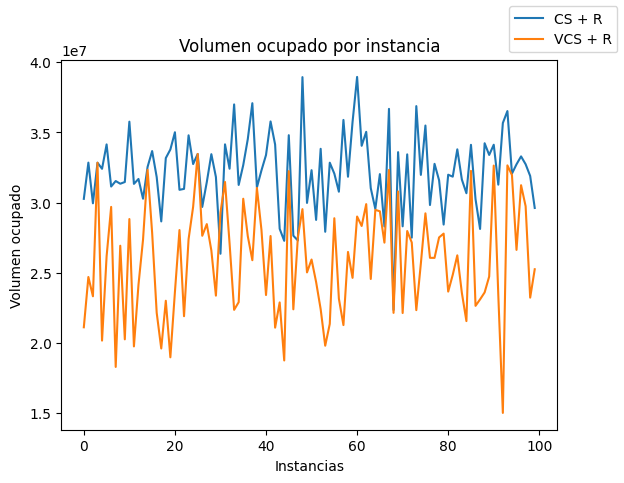

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
ax.plot(df['Instancia'],df['Volumen Ocupado'],label='CS + R')
ax.plot(df_2['Instancia'],df_2['Volumen Ocupado'],label='VCS + R')
plt.title('Volumen ocupado por instancia')
plt.xlabel('Instancias')
plt.ylabel('Volumen ocupado')
fig.legend()
plt.savefig('InstanciaVSVolumen.jpg')

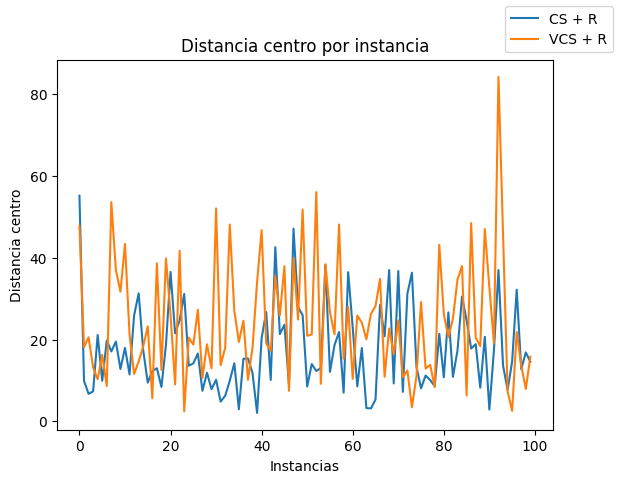

In [ ]:
fig,ax = plt.subplots()
ax.plot(df['Instancia'],df['Diferencia centro'],label='CS + R')
ax.plot(df_2['Instancia'],df_2['Diferencia centro'],label = 'VCS + R')
plt.xlabel('Instancias')
plt.ylabel('Distancia centro')
plt.title('Distancia centro por instancia')
fig.legend()
plt.savefig('InstanciaVSCentro.jpg')

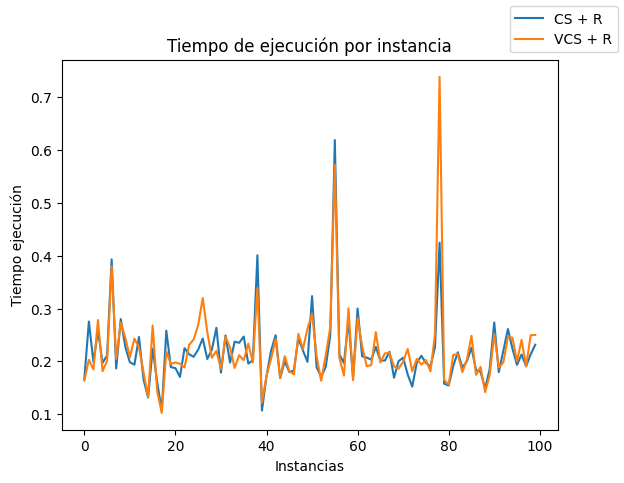

In [ ]:
fig,ax = plt.subplots()
ax.plot(df['Instancia'],df['Tiempo ejecucion'],label='CS + R')
ax.plot(df_2['Instancia'],df_2['Tiempo ejecucion'],label = 'VCS + R')

plt.xlabel('Instancias')
plt.ylabel('Tiempo ejecución')
plt.title('Tiempo de ejecución por instancia')
fig.legend()
plt.savefig('InstanciaVSTiempo.jpg')